In [1]:
using StatsBase
using Combinatorics
using Plots
using Optim

include("jl/omega.jl")
include("jl/HSBM.jl")
include("jl/read_data.jl")
include("jl/inference.jl")
include("jl/objectives.jl");

Ok, so I think the way this works is that `myfunc` is going to supply the update in the gradient by modifying it in place. This seems very smart -- each function call updates the gradient. So, what we would need to do evaluate the relevant sums and cut terms, then follow this pattern. 

In [43]:
dataset = "congress-bills"
kmax_ = 15

H, Z = read_hypergraph_data(dataset,kmax_)

kmax = maximum(keys(H.E))
K = 1:kmax

α0 = vcat(1 .+ rand(kmax),  0.25.+0.5*rand(kmax));
n = 1*length(H.D)

#######################
# SPECIFIED BY USER
#######################

function ω(p, α)
    k = sum(p)
    return sum(p)/sum((p .* (1:length(p)).^α[k])) / n^(α[kmax+k]*k)
end

Ω = buildΩ(ω, α0, kmax)

function dΩ(p;α,mode="partition")
    coef = Ω(p;α=α0,mode="partition")^2/sum(p)
    grad = zero(α)
    k = sum(p)
    I = 1:length(p)
    
    grad[k]      = n^(α[kmax+k]*k)*sum(p.*(I.^α[k]).*log.(I))
    grad[kmax+k] = k*log(n)*n^(α[kmax+k]*k)*sum((p.*(I).^α[k]))
    return coef*grad
end

#######################
# BUILT IN
#######################

ℓ = maximum(k for k in keys(H.E)) # size of largest hyperedge

C       = evalCuts(Z,H)
V, μ, S = evalSums(Z,H,ℓ,true);

α = α0
res = 0

function objective(α)
    obj = 0
    for p in keys(S)
        Op   = Ω(p; α=α, mode="partition")
        obj += C[p]*log(Op) - S[p]*Op
    end
    return -obj # sign is for minimization
end

function gradient(α)
    grad = zero(α)
    for p in keys(S)
        k     = sum(p)        
        Op    =  Ω(p; α=α, mode="partition")
        g     = dΩ(p; α=α, mode="partition")
        grad += (C[p]/Op - S[p])*g
    end
    return -grad
end

function objective(β,γ)
    α = vcat(β,γ)
    return objective(α)
end

function gradient(β, γ)
    α = vcat(β,γ)
    gradient(α)
end

gradient (generic function with 2 methods)

This function appears to be VERY ill-conditioned, which makes sense, and which motivates the idea that, rather than trying to optimize batches of parameters at once, we should instead just find an elegant way to do this coordinate-by-coordinate. Probably much faster. 

In [ ]:
# with gradients

β0 = 1 .+ rand(kmax)
γ0 = repeat([1.0],kmax)

β=β0
γ=γ0

for i = 1:20
    # optimization in γ
    res = optimize(γ -> objective(β,γ), 
#                    γ -> gradient(β,γ)[(kmax+1):(2*kmax)],  
                   γ, 
                   Optim.Options(iterations = 10);
                   inplace = false) 
    γ = Optim.minimizer(res)

    res = optimize(β->objective(β, γ), β, Optim.Options(iterations = 10)) # optimization in β
    β = Optim.minimizer(res)
    
    println(-Optim.minimum(res))
end

-5.724005462822917e24
-4.525385090767062e20
-4.3863804637497037e18


In [31]:
# without gradients

β0 = 1 .+ rand(kmax)
γ0 = repeat([1.0],kmax)

β=β0
γ=γ0

for i = 1:20
    res = optimize(γ->objective(β, γ), γ, Optim.Options(iterations = 1000)) # optimization in γ
    γ = Optim.minimizer(res)

    res = optimize(β->objective(β, γ), β, Optim.Options(iterations = 1000)) # optimization in β
    β = Optim.minimizer(res)
    
    println(-Optim.minimum(res))
end

-4.789845455046135e6
-4.73603904674764e6
-4.73343944869366e6
-4.731348401537946e6
-4.729610634486474e6
-4.72785918783438e6
-4.726292876059005e6
-4.725015988047738e6
-4.723957951488233e6
-4.723069158340753e6
-4.722313311704844e6
-4.72166340049962e6
-4.721099382550324e6
-4.720606494263571e6
-4.720173917406147e6
-4.719793675441296e6
-4.719459738607802e6
-4.719167366222982e6
-4.718912568564369e6
-4.718691778479099e6


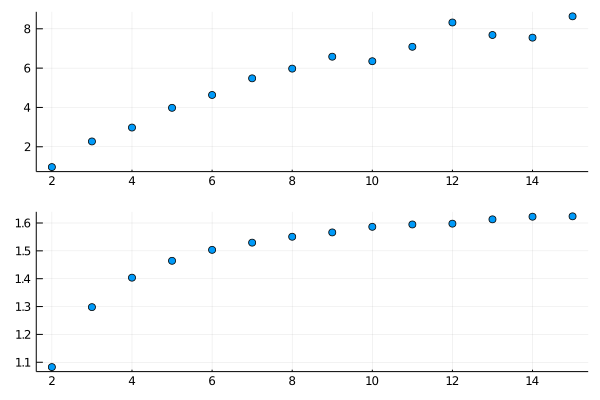

In [32]:
l = @layout [a ; b]
p1 = plot(2:kmax, β[2:kmax], seriestype = :scatter, label = "")
p2 = plot(2:kmax, γ[2:kmax], seriestype = :scatter, label = "")
plot(p1, p2, layout = l)

In [42]:
v = sort(collect(keys(H.E)))

kmax = maximum(v)
    
K_map = Dict(v[i] => i for i in 1:length(v))

lk = length(K_map)
α0 = vcat(1 .+ rand(kmax),  1 .+0.5*rand(kmax))

n = 1*length(H.D)

function ω(p, α, K_map)
    k_ = sum(p)
    if haskey(K_map, k_) 
        k = K_map[k_]
        return sum(p)/sum((p .* (1:length(p)).^α[k])) / n^(α[lk+k]*k_)
    else
        return 1
    end
end

Ω = buildΩ((p, α) -> ω(p,α,K_map), α0, kmax);
 
# function dΩ(p;α,mode="partition")
#     coef = -Ω(p;α=α0,mode="partition")^2/sum(p)
#     grad = zero(α)
#     k_ = sum(p)
#     if haskey(K_map, k_) 
#         k = K_map[k_]
#         I = 1:length(p)
#         grad[k]    = n^(α[lk + k]*k_)*sum(p.*(I.^α[k]).*log.(I))
#         grad[lk+k] = k*log(n)*n^(α[lk+k]*k_)*sum((p .* (I).^α[k]))
#     else
#         return 0
#     end
#     return -coef*grad
# end


ℓ = maximum(k for k in keys(H.E)) # size of largest hyperedge

C       = evalCuts(Z,H)
V, μ, S = evalSums(Z,H,ℓ,true);

α = α0
res = 0

function objective(β, γ) 
    α = vcat(β, γ)
    obj = 0
    for p in keys(S)
        Op   = Ω(p; α=α, mode="partition")
        obj += C[p]*log(Op) - S[p]*Op
    end
    return -obj # sign is for minimization
end



# function objective(γ) # size
    
    
# end


# function gradient!(G, α)
#     grad = zero(α)
#     for p in keys(S)
#         k_    = sum(p)
#         k = K_map[k_]
        
#         Op    =  Ω(p; α=α, mode="partition")
#         g     = dΩ(p; α=α, mode="partition")
#         grad[k] += (C[p]/Op - S[p])*g
#     end
#     G[:] = -grad # sign is for minimization
# end



objective (generic function with 2 methods)

In [48]:
β0 = 1 .+ rand(kmax)
γ0 = 1 .+0.5*rand(kmax)

β=β0
γ=γ0

for i = 1:10
    res = optimize(γ->objective(β, γ), γ, Optim.Options(iterations = 10000)) # optimization in γ
    γ = Optim.minimizer(res)

    res = optimize(β->objective(β, γ), β, Optim.Options(iterations = 10000)) # optimization in β
    β = Optim.minimizer(res)
    
    println(-Optim.minimum(res))
end

-2.836110084744151e6
-2.834062338873241e6
-2.832573181036383e6
-2.8314420436852104e6
-2.8305669356553033e6
-2.829883550781105e6
-2.829347718882269e6
-2.8289274836082137e6
-2.828598740823723e6
-2.8283427378211566e6


In [40]:
res = optimize(objective, gradient!, α0, 
               GradientDescent(), 
               Optim.Options(iterations = 100000))

MethodError: MethodError: no method matching +(::Float64, ::Array{BigFloat,1})
Closest candidates are:
  +(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:529
  +(::Float64, !Matched::Float64) at float.jl:401
  +(::AbstractFloat, !Matched::Bool) at bool.jl:106
  ...

In [41]:
α̂ = Optim.minimizer(res)
α0

20-element Array{Float64,1}:
 -0.03748520535951538
 -0.08509988808827984
  0.005490616613270438
  0.02879843206058963
  0.16483904547012762
  0.132165796603809
  0.18433265003467092
  0.18730402149655623
  0.04651070040667471
  0.046962153065030376
 -0.10656700086840143
 -0.1854079757556646
 -0.1426937568764668
 -0.1221836257316713
  0.1017352539748968
  0.09721540282158636
  0.1211124589942929
  0.18792388628603218
  0.07825998424066594
  0.12797471316055087

In [6]:
p = [3, 2, 1]

G = zero(α)

# gradient!(G, α)

MethodError: MethodError: no method matching +(::Float64, ::Array{BigFloat,1})
Closest candidates are:
  +(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:529
  +(::Float64, !Matched::Float64) at float.jl:401
  +(::AbstractFloat, !Matched::Bool) at bool.jl:106
  ...